In [3]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
size = 224
batch_size = 100
num_workers = 16

In [6]:


train_transforms =  transforms.Compose([
        transforms.CenterCrop(size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

val_transforms = transforms.Compose([
        transforms.CenterCrop(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
train_dataset = datasets.ImageFolder(root = "./dataset/train/",
                                     transform = train_transforms)
val_dataset = datasets.ImageFolder(root="./dataset/val/", transform = val_transforms)

In [20]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, shuffle=True, batch_size = batch_size,
                                     num_workers=num_workers)

validation_loader = torch.utils.data.DataLoader(dataset = val_dataset, shuffle=False, batch_size = batch_size,
                                     num_workers=num_workers)

In [21]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
        
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


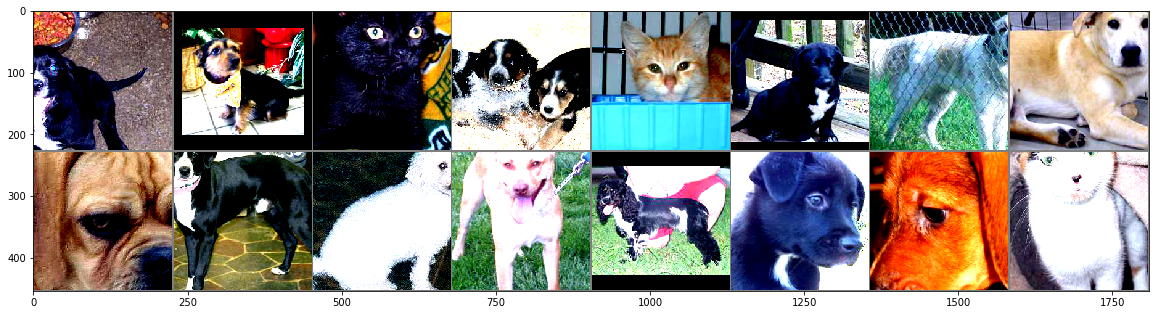

In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()


# show images
imshow(torchvision.utils.make_grid(images))

In [24]:
Alexnet = AlexNet() 

In [25]:
conv_list = [0,3,6,8,10]
fc_list = [1,4,6]
for i in conv_list:
    torch.nn.init.kaiming_normal_(Alexnet.features[i].weight)
for i in fc_list:
    torch.nn.init.kaiming_normal_(Alexnet.classifier[i].weight)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [27]:
Alexnet = Alexnet.cuda()
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(Alexnet.parameters(), lr=0.001)

In [28]:
%%time
import time

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.8 µs


In [ ]:
num_epochs = 50

train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

for epoch in range(num_epochs):
    
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    Alexnet.train()
    
    for i, (inputs,labels) in enumerate(train_loader):
    
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        optimizer.zero_grad()            
        outputs = Alexnet(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.item()       
        loss.backward()                  
        optimizer.step()                
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
        
    train_loss.append(iter_loss/iterations)
    train_accuracy.append((100 * correct / len(train_dataset)))
    
    loss = 0.0
    correct = 0
    iterations = 0
    
    Alexnet.eval()
    
    for i, (inputs, labels) in enumerate(validation_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        with torch.no_grad():
            outputs = Alexnet(inputs)     
            loss = loss_fn(outputs, labels) # Calculate the loss
            loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1
    
    
    val_loss.append(loss/iterations)
    val_accuracy.append((100 * correct / len(val_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Loss: {:.3f},  Acc: {:.3f}, Time: {}s'
        .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], val_loss[-1], val_accuracy[-1], stop-start))
        


In [15]:
torch.save(Alexnet.state_dict(),'Alexnet-Cats-Dogs-2.pth')

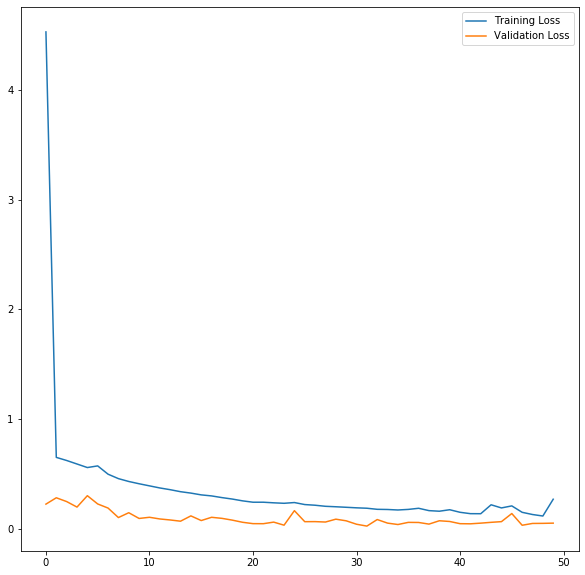

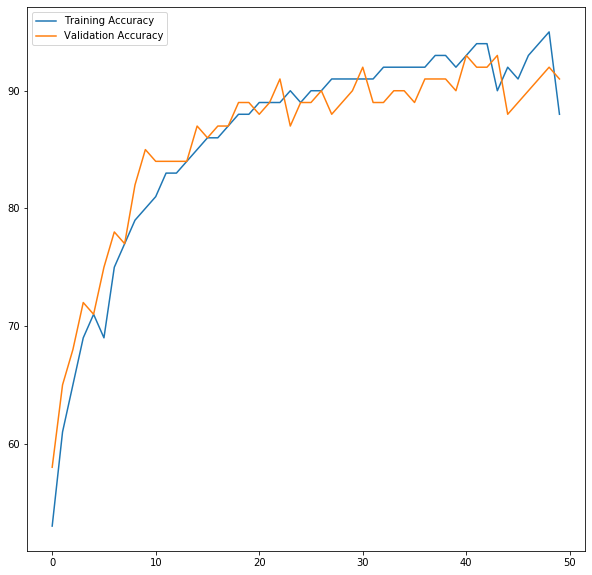

In [16]:
# loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.show()